In [1]:
from fastai.tabular.all import *
import numpy as np

In [2]:
matches_df = pd.read_csv('./datasets/20220919_out.csv')
matches_df.tail()

,Unnamed: 0,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,...,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score,rank_difference,average_rank,score_difference,is_win_loss_draw,is_won,is_stake
23916,23916,2022-06-14,Moldova,Andorra,Europe,Europe,180,153,932,1040,...,NaN,NaN,NaN,NaN,27,166.5,1,0,True,True
23917,23917,2022-06-14,Liechtenstein,Latvia,Europe,Europe,192,135,895,1105,...,NaN,NaN,NaN,NaN,57,163.5,-2,2,False,True
23918,23918,2022-06-14,Chile,Ghana,South America,Africa,28,60,1526,1387,...,78.2,75.5,76.0,78.2,-32,44.0,0,1,False,True
23919,23919,2022-06-14,Japan,Tunisia,Asia,Africa,23,35,1553,1499,...,77.5,70.8,72.3,74.0,-12,29.0,-3,2,False,True
23920,23920,2022-06-14,Korea Republic,Egypt,Asia,Africa,29,32,1519,1500,...,73.8,NaN,79.3,70.8,-3,30.5,3,0,True,False


In [3]:
len(matches_df)

23921

In [4]:
matches_df.dtypes
g = matches_df.columns.to_series().groupby(matches_df.dtypes).groups
g

{bool: ['neutral_location', 'is_won', 'is_stake'], int64: ['Unnamed: 0', 'home_team_fifa_rank', 'away_team_fifa_rank', 'home_team_total_fifa_points', 'away_team_total_fifa_points', 'home_team_score', 'away_team_score', 'rank_difference', 'score_difference', 'is_win_loss_draw'], float64: ['home_team_goalkeeper_score', 'away_team_goalkeeper_score', 'home_team_mean_defense_score', 'home_team_mean_offense_score', 'home_team_mean_midfield_score', 'away_team_mean_defense_score', 'away_team_mean_offense_score', 'away_team_mean_midfield_score', 'average_rank'], object: ['date', 'home_team', 'away_team', 'home_team_continent', 'away_team_continent', 'tournament', 'city', 'country', 'shoot_out', 'home_team_result']}

In [10]:
# classification 0: won, 1: draw, 2: loss
cat_names = ["is_stake", 'home_team', 'away_team', 'is_won']#, 'date']
cont_names = ["average_rank", "rank_difference"]#, "score_difference"]

# 17882
dls_reg_score = TabularDataLoaders.from_df(matches_df, y_names=['home_team_score', 'away_team_score'], bs=32, valid_idx=list(range(17882, 23921)),
    cat_names = cat_names,
    cont_names = cont_names,
    procs = [Categorify, Normalize, FillMissing])


In [15]:
# custom loss function
def loss(preds, targets): 
    preds = torch.round(preds)
    batch_size = preds.shape[0]
    sum_error = 0.0

    for i in range(batch_size):
        if preds[i][0] == targets[i][0] and preds[i][1] == targets[i][1]:
            sum_error += 0.0
        elif preds[i][0] == preds[i][1] and targets[i][0] == targets[i][1]:
            sum_error += 1.0
        elif preds[i][0] - preds[i][1] == targets[i][0] - targets[i][1]:
            sum_error  += 0.5
        elif preds[i][0] > preds[i][1] and targets[i][0] > targets[i][1]:
            sum_error  += 1.0
        elif preds[i][0] < preds[i][1] and targets[i][0] < targets[i][1]:
            sum_error  += 1.0
        else:
            sum_error  += 4.0

    return torch.tensor([sum_error/batch_size], dtype=torch.float, requires_grad=True)

# regression learner
learn = tabular_learner(dls_reg_score, layers=[1000,500], y_range=[0,6])#, loss_func=loss)

SuggestedLRs(valley=0.010964781977236271)

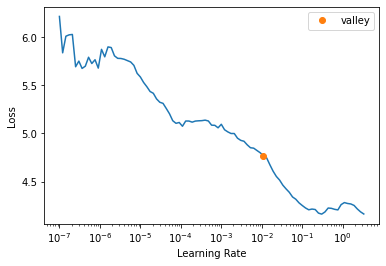

In [16]:
learn.lr_find()

In [17]:
learn.fit_one_cycle(5, 10e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,1.682930,1.990380,00:07
1,1.416410,1.391006,00:07
2,1.310108,1.208268,00:07
3,1.169571,1.198866,00:07
4,1.198224,1.199992,00:07


In [18]:
learn.show_results()

,is_stake,home_team,away_team,is_won,average_rank,rank_difference,home_team_score,away_team_score,home_team_score_pred,away_team_score_pred
0,2.0,60.0,44.0,1.0,-1.417496,0.336655,0.0,2.0,0.588051,1.346229
1,2.0,167.0,164.0,1.0,-0.503872,1.123790,1.0,1.0,0.548768,1.283216
2,2.0,13.0,208.0,1.0,-1.338541,0.355853,2.0,2.0,0.580714,1.493459
3,2.0,67.0,211.0,1.0,1.131628,-0.085710,1.0,1.0,0.519209,1.201475
4,2.0,97.0,181.0,2.0,0.296959,-1.698377,2.0,0.0,2.670190,0.435567
5,2.0,163.0,95.0,2.0,-0.334682,-0.623266,3.0,2.0,2.280539,0.442947
6,1.0,3.0,188.0,2.0,0.578942,-1.602385,4.0,1.0,2.629176,0.463577
7,2.0,33.0,166.0,2.0,1.605359,-1.314408,2.0,0.0,2.408765,0.403648
8,2.0,68.0,172.0,2.0,1.830945,-1.659980,2.0,0.0,3.206888,0.277208


In [19]:
learn.export("./20221015_model_reg")